# Import modules

In [1]:
from IPython.display import clear_output

import os
import glob
from pathlib import Path
import time
import copy
import numbers
import math

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2 as cv

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler

from torch.utils.data import random_split
from torch.utils.data.dataset import Dataset

from torchvision import datasets, transforms, models
from torchvision.datasets.utils import download_url, extract_archive
from torchvision.utils import make_grid

import torchmetrics

# Download dataset

In [2]:
root = './'
filename = 'data.zip'
archive = os.path.join(root, filename)
url = 'https://sid.erda.dk/share_redirect/heaAFNnmaG/data.zip'
data_folder = os.path.join(root, 'data/images')
force_download = False
if (not os.path.exists(data_folder) or force_download):
    download_url(url, root, filename)
    extract_archive(archive, './data', False)

# Get image folder metrics

In [3]:
widths = []
heights = []

for filename in glob.iglob(data_folder + '/**/*.jpg', recursive=True):
    im = Image.open(filename)
    widths.append(im.size[0])
    heights.append(im.size[1])

widths = np.array(widths)
heights = np.array(heights)
avg_height = round(heights.mean())
avg_width = round(widths.mean())
min_height = heights.min()
min_width = widths.min()
max_height = heights.max()
max_width = widths.max()

print(avg_height, avg_width)
print(min_height, min_width)
print(max_height, max_width)

201 399
65 141
740 1568


# Import dataset

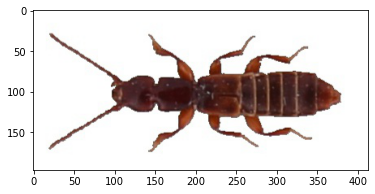

In [4]:
dataset = datasets.ImageFolder(data_folder)
image, label = dataset[0]
plt.imshow(image)

# Split dataset into train, validation and test sets

In [5]:
train_len = int(0.8 * len(dataset))
val_len = int(0.1 * len(dataset))
test_len = len(dataset) - (train_len + val_len)
dataset_lengths = [train_len, val_len, test_len]
dataset_sizes = {'train': train_len, 'val': val_len, 'test': test_len}
train_data, val_data, test_data = random_split(dataset, dataset_lengths)

# Apply augmentations

## functions for performing transform on Subset class

In [6]:
class TransformsDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

## apply basic rescaling and tensorfication

In [7]:
img_height = round(200/0.95)  # or 256
img_width = round(400/0.95)
img_height_crop = 224
img_width_crop = 448

resize_default = transforms.Resize((img_height_crop, img_width_crop))
tensorfy = transforms.ToTensor()
transforms_pre_norm = transforms.Compose(
    [resize_default, tensorfy]
)
train_data_pre_norm = TransformsDataset(train_data, transforms_pre_norm)

## Get dataset mean and std

In [8]:
loader = torch.utils.data.DataLoader(
    train_data_pre_norm,
    batch_size=1,
    num_workers=0,
    shuffle=False
)
cnt = 0
fst_moment = torch.empty(3)
snd_moment = torch.empty(3)

for data, labels in loader:

    b, c, h, w = data.shape
    nb_pixels = b * h * w
    sum_ = torch.sum(data, dim=[0, 2, 3])
    sum_of_square = torch.sum(data ** 2, dim=[0, 2, 3])
    fst_moment = (cnt * fst_moment + sum_) / (cnt + nb_pixels)
    snd_moment = (cnt * snd_moment + sum_of_square) / (cnt + nb_pixels)

    cnt += nb_pixels
mean = fst_moment
std = torch.sqrt(snd_moment - fst_moment ** 2)
#imagenet_mean = [0.485, 0.456, 0.406]
#imagenet_std = [0.229, 0.224, 0.225]
print(mean, std)


tensor([0.8445, 0.8255, 0.8236]) tensor([0.2895, 0.3222, 0.3238])


## Apply transformation with normalization

In [9]:
normalize = transforms.Normalize(mean, std)
transforms_norm = transforms.Compose(
    [transforms_pre_norm, normalize]
)

train_data_norm = TransformsDataset(train_data_pre_norm, normalize)

val_data_norm = TransformsDataset(val_data, transforms_norm)
test_data_norm = TransformsDataset(test_data, transforms_norm)

## Extra transformation sequences (not used currently)

In [10]:
resize = transforms.Resize((img_height, img_width))
center_crop = transforms.CenterCrop((img_height_crop, img_width_crop))

rotate = transforms.RandomRotation((-3, 3))
random_crop = transforms.RandomCrop((img_height_crop, img_width_crop))
vertical_flip = transforms.RandomVerticalFlip(0.5)

test_transforms = transforms.Compose(
    [resize, center_crop, tensorfy, normalize]
)
train_transforms = transforms.Compose([
    resize, rotate, random_crop,
    vertical_flip, tensorfy, normalize]
)

# Initialize data-loaders

In [11]:
# number of threads to handle data. bug makes ipynb hang when num > 0.
num_workers = 0
# larger size induces faster convergence (usually) but be wary, your GPU might run out of memory. 
# Also smaller sizes induces learning which generalize better.
batch_size = 8

train_loader = torch.utils.data.DataLoader(train_data_norm, batch_size=batch_size,
                                            num_workers=num_workers, shuffle = True)
val_loader = torch.utils.data.DataLoader(val_data_norm, batch_size=batch_size,
                                        num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data_norm, batch_size=batch_size,
                                        num_workers=num_workers)
data_loaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}


In [12]:
def imshow(inp, title=None, mean = mean, std = std):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

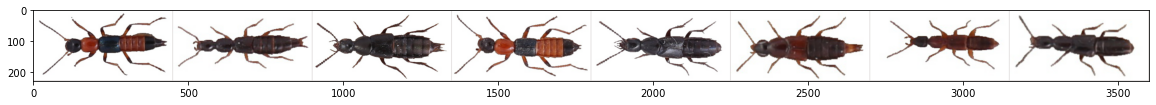

In [13]:
iterable = iter(train_loader)
images, labels = next(iterable)
img_grid = make_grid(images, nrow = 8)
plt.figure(figsize = (20,20))
imshow(img_grid)

# Define the classification model

In [14]:
# start by setting up device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# now use resnet18 pretrained with last layer replaced
#model = models.resnet18(pretrained=True)
# consider using resnet50 instead
model = models.resnet50(pretrained=True)
num_fc = model.fc.in_features

# were just counting the number of classes by counting subfolders in image folder
num_classes = len(next(os.walk(data_folder))[1])
model.fc = nn.Linear(num_fc, num_classes)
# used for later
model = model.to(device)

# what kind of objective will we be using for our classification?
# we are dealing with multiclass classification so cross entropy loss makes sense
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized (i.e. all layers are unfrozen)

# using ADAM (usually better than SGD but seems to diverge in this case)
optimizer = optim.Adam(model.parameters(), lr = 0.001, eps = 0.1)
# using stochastic gradient descent (default)
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs (experiment with this)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Early stopping class

In [15]:
class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """

    def __init__(self, patience=5, min_delta=0):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(
                f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

# Define model trainer

In [16]:
def fit(model, data_loaders, dataset_sizes, criterion, 
                optimizer, early_stopping, scheduler = None,
                num_epochs=100, device="cuda:0"):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_loss, train_acc = [], []
    val_loss, val_acc = [], []
    epochs = []

    for epoch in range(num_epochs):
        epochs.append(epoch)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in data_loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = (running_corrects.double()).item() / dataset_sizes[phase]
            if phase == 'train':
                if scheduler != None:
                    scheduler.step()
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc)
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                early_stopping(epoch_loss)
        clear_output(wait=True)
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                'Train', train_loss[-1], train_acc[-1]))
        print('{} Loss: {:.4f} Acc: {:.4f}'.format(
            'Val', val_loss[-1], val_acc[-1]))
        print()
        if early_stopping.early_stop:
            break       
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    metrics = np.array([epochs, train_loss, train_acc, 
                        val_loss, val_acc]).T
    return model, metrics

# Load and or train model

In [17]:
load_model = True
train_model = False
location = torch.device(device)
if load_model == True:
    model.load_state_dict(torch.load(
        'models/model_0_parameters.pt', 
        map_location=location))
    #optimizer.load_state_dict(torch.load('models/model_0_optimizer.pt'))
    data_loaders = torch.load(
        'models/model_0_dataloaders.pt', 
        map_location=location)
    metrics = np.load('models/model_0_metrics.npy')
if train_model == True:
    model, metrics = fit(model, data_loaders, dataset_sizes,criterion, 
                                optimizer,  EarlyStopping(), device = device)
_ = model.eval()

Epoch 16/99
----------
Train Loss: 0.0159 Acc: 0.9996
Val Loss: 0.3077 Acc: 0.9172

Training complete in 128m 27s
Best val Acc: 0.927286


# Test the model

In [18]:
correct = 0
total = 0
with torch.no_grad():
    for data in data_loaders['test']:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on test images: %.2f %%' %
      (100 * correct / total))

Accuracy of the network on test images: 91.66 %


# Save trained model and metrics

In [19]:
Path("models").mkdir(parents=True, exist_ok=True)
torch.save(model.state_dict(), 'models/model_0_parameters.pt')
#torch.save(optimizer.state_dict(), 'models/model_0_optimizer.pt')
torch.save(data_loaders, 'models/model_0_dataloaders.pt')
np.save('models/model_0_metrics', metrics)

# plot metrics

In [20]:
def multiplot(systems, x_axis, y_axis, labels, name, title=None, dpi=200):
    plt.figure()
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    for i in range(len(systems)):
        plt.plot(systems[i, 0], systems[i, 1], label=labels[i])
        plt.title(title, pad = 20)
    plt.legend()
    plt.grid()
    plt.savefig('figures/'+name,  bbox_inches='tight', facecolor='w', dpi=dpi)
    plt.show()
    plt.close()

In [21]:
epochs = metrics[:,0]
remaining_metrics = metrics[:,1:]
systems = np.array([[epochs, metric] for metric in remaining_metrics.T])

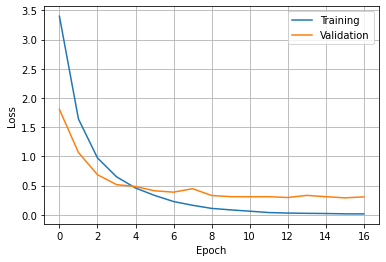

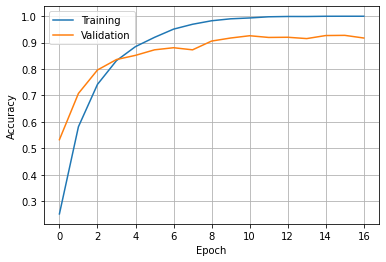

In [22]:
labels = ['Training', 'Validation']
name = 'loss_comparison.pdf'
multiplot(systems[[0,2]], 'Epoch', 'Loss', labels, name)
labels = ['Training', 'Validation']
name = 'accuracy_comparison.pdf'
multiplot(systems[[1, 3]], 'Epoch', 'Accuracy', labels, name)

# Expose layers in Resnet

In [23]:
class Dreamnet50(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = copy.deepcopy(model)
        self.layers = {}
        for param in self.model.parameters():
            param.requires_grad = False
        for (name, layer) in self.model.named_children():
            if isinstance(layer, nn.Sequential):
                for (i, sub_layer) in enumerate(layer):
                    self.layers[(name + '_'+str(i))] = sub_layer
            else:
                self.layers[name] = layer     
    def forward(self, x, out_names, idx = None):
        out_activations = {}
        for (name, layer) in self.layers.items():
            if name == 'fc':
                x = x.view(x.size(0), -1)
            x = layer(x)
            if name in out_names:
                if idx == None:
                    out_activations[name] = x
                else:
                    out_activations[name] = x[:,idx]
        return out_activations

In [24]:
dreamnet = Dreamnet50(model)
dreamnet.eval()
print(dreamnet.layers.keys())

dict_keys(['conv1', 'bn1', 'relu', 'maxpool', 'layer1_0', 'layer1_1', 'layer1_2', 'layer2_0', 'layer2_1', 'layer2_2', 'layer2_3', 'layer3_0', 'layer3_1', 'layer3_2', 'layer3_3', 'layer3_4', 'layer3_5', 'layer4_0', 'layer4_1', 'layer4_2', 'avgpool', 'fc'])


In [25]:
activations = dreamnet(images[0].unsqueeze(0), ['fc'], 20)
for activation in activations.values():
    print(activation)

tensor([-0.1653], device='cuda:0')


# Create image scale space

In [26]:
def input_adapter(tensor, device = device):
    tensor = tensor.to(device).unsqueeze(0)
    tensor.requires_grad = True
    return tensor

def output_adapter(tensor):
    return tensor.to('cpu').detach().squeeze(0)

In [27]:
def scale_level(tensor, start_size, level, ratio=1.8, 
                    levels=4, device = device):
    exponent = level - levels + 1
    h,w = np.int32(np.float32(start_size) * (ratio ** exponent))
    # we resize tensors directly instead of PIL images. 
    # The difference here is that resizing on PIL images does automatic antialiasing
    # Note that the cv.resize used elsewhere does not use antialiasing
    scale_tensor = transforms.Resize((h, w))(tensor)
    scale_tensor = input_adapter(scale_tensor, device)
    return scale_tensor

In [32]:
def scale_space(image, ratio = 1.8, levels = 4, device = device):
    scaled_tensors = []
    x,y = image.size
    dream_transform = transforms.Compose([tensorfy, normalize])
    tensor = dream_transform(image)
    for level in range(levels):
        scaled_tensor = scale_level(tensor, (y,x), level, device = device)
        scaled_tensors.append(scaled_tensor)
    return scaled_tensors

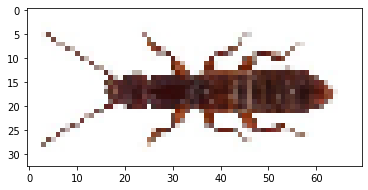

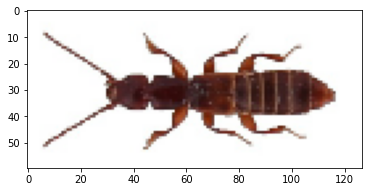

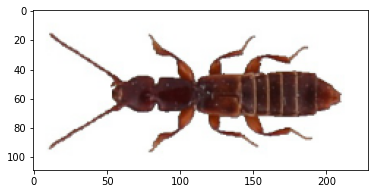

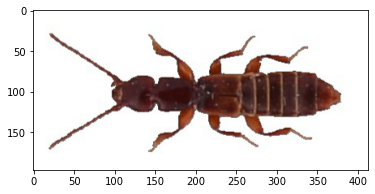

In [33]:
for scaled_img in scale_space(image):
    imshow(output_adapter(scaled_img))

# random shift utility function

In [34]:
def random_shift(tensor, h_shift, w_shift, undo=False):
    if undo:
        h_shift = -h_shift
        w_shift = -w_shift
    with torch.no_grad():
        rolled = torch.roll(tensor, shifts=(h_shift, w_shift), dims=(2, 3))
        rolled.requires_grad = True
        return rolled

# Gaussian blurring/smoothing (I dont understand it yet)

In [35]:
class CascadeGaussianSmoothing(nn.Module):
    """
    Apply gaussian smoothing separately for each channel (depthwise convolution).

    Arguments:
        kernel_size (int, sequence): Size of the gaussian kernel.
        sigma (float, sequence): Standard deviation of the gaussian kernel.

    """

    def __init__(self, kernel_size, sigma, device = device):
        super().__init__()

        if isinstance(kernel_size, numbers.Number):
            kernel_size = [kernel_size, kernel_size]

        # std multipliers, hardcoded to use 3 different Gaussian kernels
        cascade_coefficients = [0.5, 1.0, 2.0]
        sigmas = [[coeff * sigma, coeff * sigma]
                  for coeff in cascade_coefficients]  # isotropic Gaussian

        # assure we have the same spatial resolution
        self.pad = int(kernel_size[0] / 2)

        # The gaussian kernel is the product of the gaussian function of each dimension.
        kernels = []
        meshgrids = torch.meshgrid(
            [torch.arange(size, dtype=torch.float32) for size in kernel_size])
        for sigma in sigmas:
            kernel = torch.ones_like(meshgrids[0])
            for size_1d, std_1d, grid in zip(kernel_size, sigma, meshgrids):
                mean = (size_1d - 1) / 2
                kernel *= 1 / (std_1d * math.sqrt(2 * math.pi)) * \
                    torch.exp(-((grid - mean) / std_1d) ** 2 / 2)
            kernels.append(kernel)

        gaussian_kernels = []
        for kernel in kernels:
            # Normalize - make sure sum of values in gaussian kernel equals 1.
            kernel = kernel / torch.sum(kernel)
            # Reshape to depthwise convolutional weight
            kernel = kernel.view(1, 1, *kernel.shape)
            kernel = kernel.repeat(3, 1, 1, 1)
            kernel = kernel.to(device)

            gaussian_kernels.append(kernel)

        self.weight1 = gaussian_kernels[0]
        self.weight2 = gaussian_kernels[1]
        self.weight3 = gaussian_kernels[2]
        self.conv = F.conv2d

    def forward(self, input):
        input = F.pad(input, [self.pad, self.pad,
                      self.pad, self.pad], mode='reflect')

        # Apply Gaussian kernels depthwise over the input (hence groups equals the number of input channels)
        # shape = (1, 3, H, W) -> (1, 3, H, W)
        num_in_channels = input.shape[1]
        grad1 = self.conv(input, weight=self.weight1, groups=num_in_channels)
        grad2 = self.conv(input, weight=self.weight2, groups=num_in_channels)
        grad3 = self.conv(input, weight=self.weight3, groups=num_in_channels)

        return (grad1 + grad2 + grad3) / 3

# main loop of deepdream

In [64]:
def deepdream(image, model, config):
    output_tensors = []
    (w,h)= image.size
    start_size = (h,w)
    if config['use_noise'] == 'uniform':
        (h,w) = config['noise_shape']
        image = np.random.uniform(size= (h,w,3)).astype(np.float32)
    elif config['use_noise'] == 'gaussian':
        (h, w) = config['noise_shape']
        image = np.random.normal(size=(h,w,3)).astype(np.float32)
    dream_transform = transforms.Compose([tensorfy, normalize])
    tensor = dream_transform(image)

    for level in range(config['levels']):
        scaled_tensor = scale_level(tensor, start_size, level,
                                    config['ratio'], config['levels'],  config['device'])
        for i in range(config['num_iters']):
            if config['shift'] == True:
                h_shift, w_shift = np.random.randint(
                    -config['shift_size'], config['shift_size'] + 1, 2)
                scaled_tensor = random_shift(scaled_tensor, h_shift, w_shift)
            dreamt_tensor = dream_ascent(scaled_tensor, model, i, config)
            if config['shift'] == True:
                dreamt_tensor = random_shift(dreamt_tensor, h_shift,
                                             w_shift, undo=True)
            if config['show'] == True:
                clear_output(wait=True)
                imshow(output_adapter(dreamt_tensor))
            scaled_tensor = dreamt_tensor
        tensor = output_adapter(dreamt_tensor)
        output_tensors.append(tensor)
    return output_tensors


# Perform one iteration of gradient ascent

In [65]:
def dream_ascent(tensor, model, iter, config):
    ## get activations
    activations = model(tensor, config['model_layers'], config['idx'])
    ### calculate loss on desired layers
    losses = []
    for layer_activation in activations.values():
        if config['loss_type'] == 'norm':
            loss = torch.linalg.norm(layer_activation)
        elif config['loss_type'] == 'mean_red':
            loss = torch.mean(layer_activation)
        else:
            MSE = torch.nn.MSELoss(reduction='mean')
            zeros = torch.zeros_like(layer_activation)
            loss = MSE(layer_activation, zeros)
        losses.append(loss)
    if config['loss_red'] == 'mean':
        loss = torch.mean(torch.stack(losses))
    else:
        loss = torch.sum(torch.stack(losses))
    # do backpropagation and get gradient
    loss.backward()
    grad = tensor.grad.data
    ### gaussian smoothing missing !
    if config['smooth'] == True:
        sigma = ((iter + 1) / config['num_iters']) * 2.0 + config['smooth_coef']
        smooth_grad = CascadeGaussianSmoothing(
            kernel_size=config['kernel_size'], sigma=sigma)(grad)
    else:
        smooth_grad = grad
    ### normalization of gradient
    g_std = torch.std(smooth_grad)
    g_mean = torch.mean(smooth_grad)
    if config['grad_norm'] == 'both':
        smooth_grad = smooth_grad - g_mean
        smooth_grad = smooth_grad / g_std
    elif config['grad_norm'] == 'std':
        smooth_grad /= (g_std + config['eps'])
    else:
        smooth_grad /= (g_mean + config['eps'])
    ### gradient update ####
    tensor.data += config['lr'] * smooth_grad
    tensor.grad.data.zero_()
    ### clamp gradient to avoid it diverging. vanishing/exploding gradient phenomenon?
    if config['clamp_type'] == 0:
        #imagenet_mean = np.array([0.485, 0.456, 0.406])
        #imagenet_std = np.array([0.229, 0.224, 0.225])
        image_min = torch.tensor((-config['mean'] / config['std']).reshape(1, -1, 1, 1)).to(config['device'])
        image_max = torch.tensor(((1 - config['mean']) / config['std']).reshape(1, -1, 1, 1)).to(config['device'])
    else:
        image_min, image_max = -1, 1
    tensor.data = torch.clip(tensor, image_min, image_max)
    return tensor

# Set default parameters

In [67]:
default_config = {
    'ratio': 1.8,
    'levels': 4,
    'num_iters': 10,
    'lr': 0.09,
    'model_layers': ['fc'],
    'shift' : True,
    'shift_size' : 32,
    'loss_type': 'norm',
    'loss_red': 'mean',
    'grad_norm': 'both',
    'eps': 10e-8,
    'clamp_type': 0,
    'smooth': True,
    'kernel_size': 9,
    'smooth_coef': 0.5,
    'idx' : 0,
    'mean': mean,
    'std': std,
    'show': True,
    'use_noise' : None,
    'noise_shape': (224,448),
    'device': device}

# Start dreaming

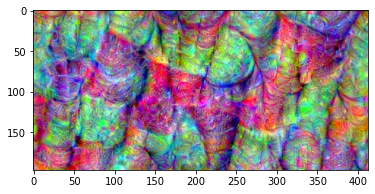

In [70]:
new_config = copy.deepcopy(default_config)
new_config['num_iter'] = 50
new_config['lr'] = 0.1
new_config['idx'] = 10
new_config['smooth_coef'] = 0
new_config['use_noise'] = 'uniform'
dream_tensors = deepdream(image, dreamnet, new_config)

In [ ]:
imshow(dream_tensors[-1])